In [1]:
%matplotlib inline 

import os
import copy
import warnings

import pickle 

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table, Column, vstack
from astropy.utils.metadata import MergeConflictWarning

from asap.utils import rank_splitting_sample

from dsigma.stack_ds import stack_delta_sigma, batch_delta_sigma
from dsigma.plots import show_delta_sigma_profiles, show_r_delta_sigma

plt.rc('text', usetex=True)

warnings.filterwarnings('ignore', category=MergeConflictWarning, 
                        append=True)

color_cycle = ['#B10318', '#DBA83A', '#309343']

### Read in the HSC galaxy catalog and pre-computed results for galaxy-galxy lensing

* Unfortunately, these data are not yet available to public

* Please contact Song Huang using shuang89@ucsc.edu if you'd like to play with these results.

In [2]:
sbp_dir = '/Users/song/data/massive/dr16a/sbp/catalog'

wl_dir = '/Users/song/data/massive/dr16a/s16a_massive_dsig'

mass_good = Table(np.load(os.path.join(wl_dir, 'lens/s16a_massive_lens_prep_new.npy')))

print("# There are %d galaxies from HSC" % len(mass_good))

# Lens and random object catalogs
lens_data = mass_good
rand_data = np.load(os.path.join(wl_dir, 'random/s16a_random_500k_prep_new.npy'))

# Pre-computed results for lenses and random objects
lens_ds = np.load(os.path.join(wl_dir, 'results/s16a_massive_lens_medium_dsig_pre.npz'))
rand_ds = np.load(os.path.join(wl_dir, 'results/s16a_massive_rand_medium_dsig_pre.npz'))

# There are 38653 galaxies from HSC


In [3]:
# Rank-splitting the sample based on the stellar mass within 10 kpc
mmax_bin_1 = rank_splitting_sample(
    mass_good, 'logm_max', 'logm_10', n_bins=60, n_sample=3, id_each_bin=False,
    X_min=11.6, X_max=12.2)

mask_1 = ((mmax_bin_1['sample_id'] == 1) & mmax_bin_1['clean_photometry'] &
          (mmax_bin_1['z'] <= 0.52))
mask_2 = ((mmax_bin_1['sample_id'] == 2) & mmax_bin_1['clean_photometry'] &
          (mmax_bin_1['z'] <= 0.52))
mask_3 = ((mmax_bin_1['sample_id'] == 3) & mmax_bin_1['clean_photometry'] &
          (mmax_bin_1['z'] <= 0.52))

# Number of galaxies in each bin
print(mask_1.sum(), mask_2.sum(), mask_3.sum())

index_1 = mmax_bin_1[mask_1]['index_ori']
index_2 = mmax_bin_1[mask_2]['index_ori']
index_3 = mmax_bin_1[mask_3]['index_ori']

1011 1030 1005


In [4]:
# Creat masks for stacking the DeltaSigma profiles
mask_empty_ori = np.full(len(mass_good), 0).astype(bool)

mask_ori_1 = copy.deepcopy(mask_empty_ori)
mask_ori_1[index_1] = True

mask_ori_2 = copy.deepcopy(mask_empty_ori)
mask_ori_2[index_2] = True

mask_ori_3 = copy.deepcopy(mask_empty_ori)
mask_ori_3[index_3] = True

### Visualize the samples across the aperture mass plane

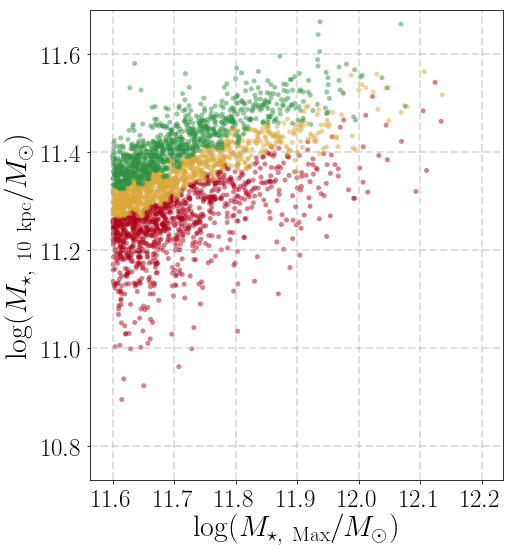

In [10]:
fig_1 = plt.figure(figsize=(7, 7.5))
fig_1.subplots_adjust(left=0.17, right=0.99, bottom=0.12, top=0.99, wspace=0.00, hspace=0.00)
ax1 = fig_1.add_subplot(111)

ax1.grid(linewidth=2.0, alpha=0.4, linestyle='--')

ax1.scatter(mass_good['logm_max'][mask_ori_1], mass_good['logm_10'][mask_ori_1], 
            s=25, alpha=0.5, c=color_cycle[0], edgecolor='none') 

ax1.scatter(mass_good['logm_max'][mask_ori_2], mass_good['logm_10'][mask_ori_2], 
            s=25, alpha=0.5, c=color_cycle[1], edgecolor='none') 

ax1.scatter(mass_good['logm_max'][mask_ori_3], mass_good['logm_10'][mask_ori_3], 
            s=25, alpha=0.5, c=color_cycle[2], edgecolor='none') 

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
ax1.set_ylim(10.73, 11.69)

_ = plt.xlabel(r'$\log (M_{\star,\ \mathrm{Max}}/M_{\odot})$', fontsize=30)
_ = plt.ylabel(r'$\log (M_{\star,\ 10\ \mathrm{kpc}}/M_{\odot})$', fontsize=30)

### Highlight the distributions of total stellar mass of these three samples

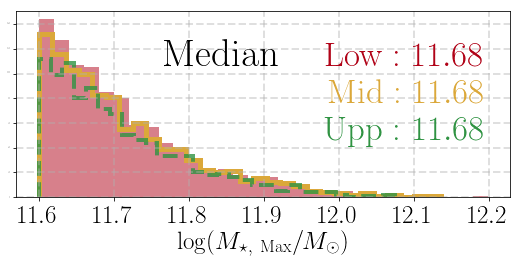

In [11]:
fig_2 = plt.figure(figsize=(7, 3.5))
fig_2.subplots_adjust(left=0.01, right=0.99, bottom=0.25, top=0.99, wspace=0.00, hspace=0.00)
ax1 = fig_2.add_subplot(111)

ax1.grid(linewidth=2.0, alpha=0.4, linestyle='--')

_ = ax1.hist(mass_good['logm_max'][mask_ori_1], bins=30, 
             color=color_cycle[0], alpha=0.5)
_ = ax1.hist(mass_good['logm_max'][mask_ori_2], bins=30, histtype='step', 
             linewidth=5, color=color_cycle[1])
_ = ax1.hist(mass_good['logm_max'][mask_ori_3], bins=30, histtype='step', 
             linewidth=4, color=color_cycle[2], alpha=0.8, linestyle='--')

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

ax1.text(0.3, 0.7, r'$\mathrm{Median\ }$', fontsize=39, transform=ax1.transAxes)
ax1.text(0.95, 0.7, r'$\mathrm{Low: %5.2f}$' % np.nanmedian(mass_good[mask_ori_1]['logm_max']),
         fontsize=35, color=color_cycle[0], horizontalalignment='right', transform=ax1.transAxes)
ax1.text(0.95, 0.5, r'$\mathrm{Mid: %5.2f}$' % np.nanmedian(mass_good[mask_ori_2]['logm_max']),
         fontsize=35, color=color_cycle[1], horizontalalignment='right', transform=ax1.transAxes)
ax1.text(0.95, 0.3, r'$\mathrm{Upp: %5.2f}$' % np.nanmedian(mass_good[mask_ori_3]['logm_max']),
         fontsize=35, color=color_cycle[2], horizontalalignment='right', transform=ax1.transAxes)

_ = plt.xlabel(r'$\log (M_{\star,\ \mathrm{Max}}/M_{\odot})$', fontsize=25)

### Stack the DeltaSigma profiles

In [5]:
mask_list = [mask_ori_1, mask_ori_2, mask_ori_3]

mmax_m10_bin_dsig = batch_delta_sigma(
    lens_ds, lens_data, mask_list, rand_data=rand_data, rand_pre=rand_ds,
    njackknife_fields=41, selection_bias=True) 

#    Sample: 1011 / 38653 galaxies
#    Number of useful jackknife regions: 41
#    Sample: 1030 / 38653 galaxies
#    Number of useful jackknife regions: 41
#    Sample: 1005 / 38653 galaxies
#    Number of useful jackknife regions: 41


In [19]:
# Save the results

np.save(mmax_m10_bin_dsig, '../data/s16a_massive_mmax_m10_split_3bins')

### Show the stacked DeltaSigma profiles

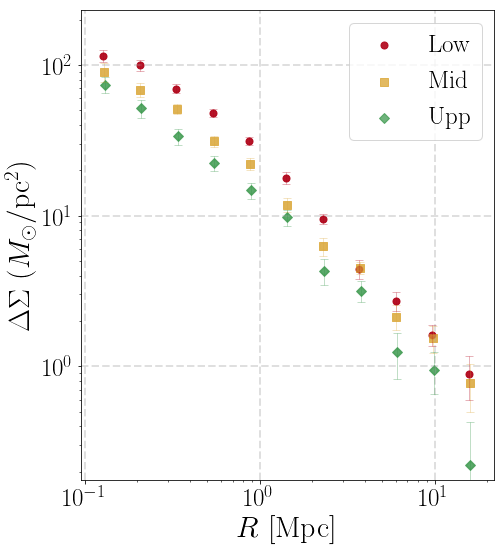

In [6]:
label_list = [r'$\mathrm{Low}$', r'$\mathrm{Mid}$', r'$\mathrm{Upp}$']

fig_3 = plt.figure(figsize=(7, 7.5))
fig_3.subplots_adjust(left=0.17, right=0.99, bottom=0.12, top=0.99, wspace=0.00, hspace=0.00)
ax1 = fig_3.add_subplot(111)

ax1 = show_delta_sigma_profiles(
    mmax_m10_bin_dsig, ax=ax1, list_label=label_list, label_size=30, legend_size=25,
    c_list=color_cycle)

### Save the figures

In [12]:
fig_1.savefig('fig/fig1_a.pdf', dpi=120)

fig_2.savefig('fig/fig1_a_hist.pdf', dpi=120)

fig_3.savefig('fig/fig1_c.pdf', dpi=120)